In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
# project files
from rp_model.const import set_files_directory

set_files_directory("./files")

from rp_model.calc import (
    game, FitOptions, download_data, refresh_pokedex, compute_rp, make_precomputed_columns, make_initial_guess
)
from rp_model.utils import (
    pack, unpack, simplify_opt_result, table, save, load, digest, progressive_soft_round_loop, RoundApprox
)

RP model file path: ./files


In [3]:
# stuff for display

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

if refresh_rp_file:
    refresh_pokedex()
    data = download_data()
    data.to_pickle(FitOptions.data_file)
else:
    data = pd.read_pickle(FitOptions.data_file)

In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.000000,9089.0,9089.000000,9089.000000,9089.000000,9089.000000
mean,12.646386,704.425789,1.605017,704.387171,-0.038618,3819.166025,3645.790296,12.722852,28.081307,39.987787,108.765211,1.073698,0.987085,0.994138,0.999670,1.007019,0.209460,36.242952,59.378590,151.510727,1.0,0.164705,7.107052,0.983665,1.034909
std,8.468468,491.199275,1.082736,491.212369,0.664380,993.379342,1061.240317,3.636166,2.610012,9.780669,15.977065,0.331364,0.058258,0.044857,0.118993,0.119303,0.047036,41.444203,31.480915,66.328039,0.0,0.746945,31.430039,0.042778,0.076922
min,1.000000,245.000000,1.000000,245.000000,-17.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.940000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,6.000000,374.000000,1.000000,374.000000,0.000000,3000.000000,2741.760000,10.000000,26.000000,33.000000,98.000000,0.820000,1.000000,1.000000,1.000000,1.000000,0.180000,14.050000,37.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,11.000000,532.000000,1.000000,532.000000,0.000000,3700.000000,3571.200000,12.000000,28.000000,38.000000,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.210000,20.750000,50.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,17.000000,824.000000,2.000000,824.000000,0.000000,4400.000000,4373.600000,15.000000,31.000000,44.000000,115.000000,1.310000,1.000000,1.000000,1.000000,1.000000,0.230000,47.800000,72.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,50.000000,5217.000000,6.000000,5220.000000,9.000000,6300.000000,6916.140000,24.000000,35.000000,107.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.430000,414.490000,321.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier,Sub Skill 3
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
1,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
2,Arbok,9.0,528.0,Bold,1.0,,528.0,0.0,Bold,ArbokBold91,Energy Recovery,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.08,1.0,1.0,0.26,22.75,538.33,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
3,Arbok,9.0,539.0,Hardy,1.0,Double Jumper,539.0,0.0,Neutral,ArbokNeutral91,-,-,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,539.00,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
4,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,


In [6]:
FitOptions.rounding.final_rp = RoundApprox.Pass
FitOptions.rounding.bonus = RoundApprox.Exact
FitOptions.rounding.period = RoundApprox.Pass
FitOptions.rounding.components = RoundApprox.Pass


In [7]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())


In [8]:
# Compute per sample information about help time, nature, subskills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    9.089000e+03
mean     2.403916e-17
std      6.024336e-17
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
Name: Helps per hour, dtype: float64

In [9]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)


def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    9089.000000
mean       -1.019804
std         1.368842
min       -14.000000
25%        -1.000000
50%        -1.000000
75%         0.000000
max        18.000000
Name: RP, dtype: float64

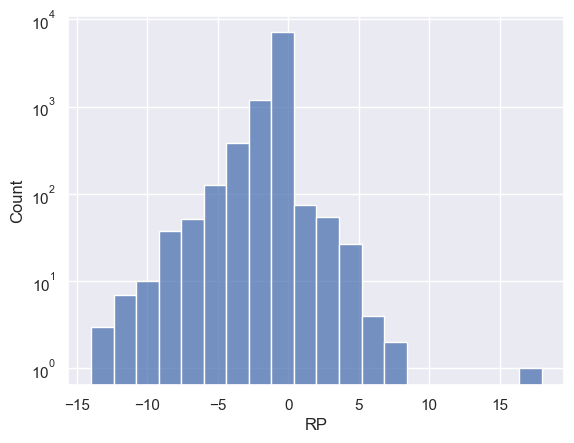

In [10]:
# what is the quality of the initial guess?

r = data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r, bins=20)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])

In [11]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = FitOptions.get_result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")

else:

    opt = progressive_soft_round_loop(x0,
        lambda x: scipy.optimize.least_squares(residual, x, **FitOptions.least_squares_kwargs)
    )

    # save results and remove some stuff we don't need to save.
    save(filename, simplify_opt_result(opt))

Loaded from cache


In [12]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.615e-01  5.444e-01 ...  3.684e-01  3.704e-01]
       cost: 1648.3333692278306
       grad: [-1.530e-05 -3.763e-05 ...  0.000e+00  0.000e+00]
 optimality: 0.0013571591365838659
       nfev: 35
       njev: 17

count    9089.000000
mean        0.002090
std         0.608312
min        -9.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        17.000000
Name: RP, dtype: float64

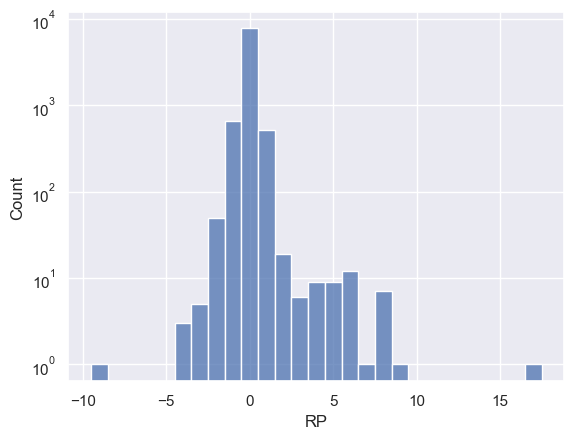

In [13]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])


In [14]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.2561451 0.25443856 0.26543782 ... 0.20566426 0.21865537 0.17941004]
Pokemons skill products,[16.70212329 16.69522645 18.45792653 ... 51.9008147 55.40652859 44.70813354]
Charge Strength S,[0.74660401 0.32247636]
Charge Strength M,[0.74514657 0.3227188 ]
Ingredient Magnet S,[0.7458781 0.3227056]
Cooking Power-Up S,[0.74485277 0.32291258]
Extra Helpful S,[0.74609823 0.32233025]
Charge Energy S,[0.74641848 0.32244629]
Energizing Cheer S,[0.7463537 0.32212581]
Energy for Everyone S,[0.74561128 0.32268703]
Dream Shard Magnet S,[0.74680831 0.32193974]


In [15]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({
    "Pokemon": game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"] * 100.0,
    "skill% * skillValue": sol["Pokemons skill products"]
})
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.614510,16.702123
Ivysaur,25.443856,16.695226
Venusaur,26.543782,18.457927
Charmander,20.028019,9.673061
Charmeleon,22.670432,14.035123
Charizard,22.338516,14.084189
Squirtle,26.997759,17.597512
Wartortle,27.036366,17.574875
Blastoise,27.410017,18.452688


In [16]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2, 7)))
growth_display["Level"] = levels

for record in game.data.mainskills.to_dict(orient='records'):

    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0] * np.exp(params[1] * levels)

df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422950,1.420861,1.422219,1.420852,1.421571,1.422511,1.421476,1.421657,1.421813,1.421801
3,1.964443,1.962035,1.963883,1.962402,1.962252,1.963778,1.961720,1.963071,1.961820,1.963332
4,2.711997,2.709329,2.711845,2.710360,2.708576,2.710996,2.707288,2.710674,2.706922,2.711118
5,3.744026,3.741250,3.744675,3.743400,3.738757,3.742533,3.736216,3.742988,3.735015,3.743718
6,5.168786,5.166206,5.170868,5.170176,5.160758,5.166569,5.156197,5.168442,5.153580,5.169611


In [17]:
# What are the worst points?

df = data[["Pokemon", "ID", "Level", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2467.735308,17.0,289.0
1,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1751.767357,9.0,81.0
2,Slaking,SlakingGentle271Inventory Up LDream Shard Bonus,27.0,1.0,Main Skill Chance,Energy Recovery,Inventory Up L,Dream Shard Bonus,1188.0,1197.108356,-9.0,81.0
3,Charizard,CharizardRash273Helping BonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping Bonus,Helping Speed M,1440.0,1431.735753,8.0,64.0
4,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1506.459778,8.0,64.0
5,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1506.459778,8.0,64.0
6,Raichu,RaichuNaughty313Helping Speed SInventory Up S,31.0,3.0,Speed of Help,Main Skill Chance,Helping Speed S,Inventory Up S,1663.0,1654.573677,8.0,64.0
7,Sylveon,SylveonRelaxed102Helping Bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping Bonus,,1023.0,1015.336032,8.0,64.0
8,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.573648,8.0,64.0
9,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1519.768031,8.0,64.0
